## Overview
This project aims to demonstrate use of LSTM Encoder-Decoder model for time series forecasting. Throughout the notebook one can see several user-defined functions to ease out the recursive use for a user. But one can simply use the logic recursively instead of functions too. Follow the inline comments to understand the codelines.

## Data Source
The data used is free source and is collected from Bloomberg and Reuters. As students of Singapore Managament University, we had access to run the systems and extract this data. I have uploaded the data as "RawData.csv". One can download the file and run the notebook.

## Import Packages

In [32]:
# import libraries
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, RepeatVector,TimeDistributed
from keras.callbacks import EarlyStopping, ModelCheckpoint,TerminateOnNaN, ReduceLROnPlateau
import math, sys, time, joblib, statistics
from statsmodels.tools.eval_measures import rmse
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from functools import partial
trials = Trials()
# path to save models
path = "Saved Models/"

## Define Functions

In [33]:
# function to prepare data
def prepare_data(start_timestep,end_timestep):
    # importing data
    data = pd.read_csv('RawData.csv')
    
    # defining dataset to model
    df = data[['Date','Target-Australia/China c5']]
    
    # converting date to pandas datetime object
    df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%y')
    
    # renaming columns
    df.columns = ['date', 'c5']
    
    # setting date as index
    df = df.set_index('date')
    
    # filtering data to remove weekends
    df = df[df.index.dayofweek < 5]
    
    # filling the holidays timestamps with previous days' data
    df = df.ffill(axis = 0)
    
    # sorting ascending - just a failsafe
    df = df.sort_index(axis = 0)
    
    # filtering data after 2018
    df = df[(df.index>=start_timestep) & (df.index<=end_timestep)]
    
    return df

In [34]:
# scaling train, validate and test - fit only on train to avoid leakage
def scaling(train,validate):
    scaler = MinMaxScaler(feature_range = (-1,1))
    scaler.fit(train)
    train_scaled = scaler.transform(train)
    validate_scaled = scaler.transform(validate)
    return(train_scaled,validate_scaled,scaler)

In [35]:
# convert data to sequential
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [36]:
# define objective function that contains the model architecture
def objective(params, X_train,Y_train, X_validate, Y_validate, path, n_steps_out):
    
    # intializing
    patience = 50
    loss = 0
    
    # defining lstm_model
    lstm_model = Sequential()

    # LSTM layer 1
    lstm_model.add(LSTM(params['units1'],
                   activation=params['activation'],
                   kernel_initializer = params['init'],
                   input_shape=(n_steps_in, n_features))) 
    lstm_model.add(Dropout(params['dropout1']))
    
    # Repeat Vector timesteps number of times
    lstm_model.add(RepeatVector(n_steps_out))
    
    # LSTM layer 2
    lstm_model.add(LSTM(params['units2'],
                   activation=params['activation'],
                   return_sequences=True,
                   kernel_initializer = params['init'])) 
    lstm_model.add(Dropout(params['dropout2']))
    
    # LSTM layer 3
    lstm_model.add(LSTM(params['units3'], 
                   activation=params['activation'], 
                   return_sequences = True, 
                   kernel_initializer = params['init']))
    lstm_model.add(Dropout(params['dropout3']))
        
    # Dense layer
    lstm_model.add(TimeDistributed(Dense(1,kernel_initializer = params['init'])))
     
    # Compile lstm_model
    lstm_model.compile(loss='mse', optimizer="adam")
    
    # model summary
    #lstm_model.summary()
    #plot_model(lstm_model, show_shapes=True,show_layer_names=True)
     
    # Early stooping criteria
    earlystop = EarlyStopping(monitor='val_loss', 
                              patience= patience, 
                              verbose=1, 
                              mode='min', 
                              restore_best_weights = True)
    
    # file name/location to save best lstm_model
    #file = path + brandcode + "{epoch:02d}-{val_loss:.2f}.h5"
    file = path + 'Best_Model.ckpt'
    
    # Saving best lstm_model
    lstm_model_selected = ModelCheckpoint(file, 
                                              monitor='val_loss',
                                              mode='min',
                                              verbose=1,
                                              save_best_only=True)													 
													
    # terminate on NaN loss - failsafe
    nan_terminate = TerminateOnNaN()
    
    # reduce learning rate gradually
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
							  factor=0.1, 
							  patience=10, 
							  verbose=1, 
							  mode='min',
							  min_delta=0.0001, 
							  cooldown=0, 
							  min_lr=0)
    
    # Use all early stopping criteria in call back list
    callbacks_list = [lstm_model_selected, 
                      earlystop,
                      nan_terminate, 
                      reduce_lr
                      ]
                      
    # Fit lstm_model
    hist = lstm_model.fit(X_train, Y_train,  
                     validation_data=(X_validate, Y_validate),
                     epochs=256, 
                     batch_size=params['batch_size'],  
                     callbacks = callbacks_list,
                     verbose = 1)
     
    # plotting losses
    plt.plot(hist.history['loss'], label='train')
    plt.plot(hist.history['val_loss'], label='validate')
    plt.title('lstm_model Losses (mse)')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend(loc = 'upper right')
    plt.show()
    
    loss = min(hist.history['loss'])
    
    return { 'loss': loss,
            'status': STATUS_OK,
            'lstm_model': lstm_model}

In [37]:
# evaluation 
def evaluation(Y_test,Y_pred): 
    # rmse
    RMSE = rmse(np.array(Y_test), np.array(Y_test_predictions))
    
    # mape
    mape = np.mean(np.abs(np.array(Y_test)-np.array(Y_test_predictions))*100/np.array(Y_test))
   
    # plotting
    plt.plot(Y_test.index,Y_test,label = 'Actual')
    plt.plot(Y_test.index,Y_pred,label = 'Predicted')
    plt.legend(loc = 'upper right')
    plt.xlabel('Date')
    plt.ylabel('C5 Index')
    plt.title('Actual Vs. Predicted')
    plt.show()
    
    return mape,RMSE

## User Inputs

In [38]:
# User Inputs - define train and test percentage and start and end time

train_p = 0.70 
validate_p = 0.30

start_timestep = '2018-01-01' # please keep the format
end_timestep = '2019-10-31'   # please keep the format

# defining model parameters
n_features = 1
n_steps_in = 10
n_steps_out = 10


## Define Model Tunable Hyperspace

In [39]:
# defining hyper space
space = {
   
    'units1': hp.choice('units1', [64,128,256]),           
    'dropout1': hp.uniform('dropout1', 0, 0.5),
    
    'units2': hp.choice('units2', [32,64,128]),
    'dropout2': hp.uniform('dropout2', 0, 1),
    
    'units3': hp.choice('units3', [16,32,64]),
    'dropout3': hp.uniform('dropout3', 0, 1),
    
    'batch_size' : hp.choice('batch_size', [30]),
        
    'activation': hp.choice('activation',['relu']),
    
    'init': hp.choice('init',['glorot_normal'])
    
        } 

## Execute Functions

In [40]:
# data preparation

# call perepare_data
df = prepare_data(start_timestep,end_timestep)

# building train, validate and test datasets
train = df.iloc[:math.ceil(train_p*len(df)),:]
validate = df.iloc[math.ceil(train_p*len(df)):math.ceil(train_p*len(df))+math.ceil(validate_p*len(df)),:]

# scaling train, validate and test datasets
train_scaled, validate_scaled, scaler = scaling(train,validate)

# splitting train, validate and test into X and Y
X_train, Y_train = split_sequence(train_scaled, n_steps_in, n_steps_out)
X_validate, Y_validate = split_sequence(validate_scaled, n_steps_in, n_steps_out)

C:\Users\hp\anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [41]:
# model safety check - sum of train, test and validate should not be greater than data size
if train_p*(len(df)) + validate_p*(len(df)) > df.shape[0]:
    sys.exit('Sum of n_train, n_validate and n_test should not be greater than the data size')

 30%|██████████████████████▌                                                    | 3/10 [00:00<?, ?trial/s, best loss=?]WARNING:tensorflow:Large dropout rate: 0.979694 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
Train on 317 samples, validate on 124 samples                                                                          
Epoch 1/256                                                                                                            
 30/317 [=>............................]                                                                               
 - ETA: 15s - loss: 0.2280                                                                                             
                                                                                                                      
 60/317 [====>.........................]                                                                               


317/317 [==============================]                                                                               
 - 0s 1ms/step - loss: 0.2288 - val_loss: 0.5213                                                                       

                                                                                                                       
Epoch 00003: val_loss did not improve from 0.46956
Epoch 4/256                                                                                                            
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.1843                                                                                              
                                                                                                                       
 90/317 [=======>......................]                                                                    

270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.2010                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.2019                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.2016 - val_loss: 0.4504                                                                       

                                       

300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.1857                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 0s 2ms/step - loss: 0.1857 - val_loss: 0.3979                                                                       

                                                                                                                       
Epoch 00009: val_loss improved from 0.41210 to 0.39792, saving model to Saved Models/Best_Model.ckpt
Epoch 10/256                                                                                                           
 30/317 [=>............................]                  

317/317 [==============================]                                                                               
 - 0s 1ms/step - loss: 0.1838 - val_loss: 0.3930                                                                       

                                                                                                                       
Epoch 00012: val_loss improved from 0.39792 to 0.39299, saving model to Saved Models/Best_Model.ckpt
Epoch 13/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.2231                                                                                              
                                                                                                                       
 90/317 [=======>......................]                  

270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.1806                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.1834                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.1821 - val_loss: 0.3897                                                                       

                                       

240/317 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.1661                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.1687                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 0s 1ms/step - loss: 0.1659 - val_loss: 0.3590                                                                       

                                       

210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.1571                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.1625                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 0s 1ms/step - loss: 0.1622 - val_loss: 0.3420                                                                       

                                       

300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.1619                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 0s 1ms/step - loss: 0.1621 - val_loss: 0.3766                                                                       

                                                                                                                       
Epoch 00024: val_loss did not improve from 0.34198
Epoch 25/256                                                                                                           
 30/317 [=>............................]                                                                    

                                                                                                                       
 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.1685                                                                                              
                                                                                                                       
150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.1723                                                                                              
                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.1681               

                                                                                                                       
180/317 [================>.............]                                                                               
 - ETA: 0s - loss: 0.1699                                                                                              
                                                                                                                       
240/317 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.1649                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.1623               

 - ETA: 0s - loss: 0.1496                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.1544                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.1541                                                                                              
                                                                                                                       
317/317 [==============================]

 - ETA: 0s - loss: 0.1496                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 0s 1ms/step - loss: 0.1531 - val_loss: 0.3874                                                                       

                                                                                                                       
Epoch 00037: val_loss did not improve from 0.34198
Epoch 38/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.1526                                                                                   

 - ETA: 0s - loss: 0.1642                                                                                              
                                                                                                                       
150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.1564                                                                                              
                                                                                                                       
180/317 [================>.............]                                                                               
 - ETA: 0s - loss: 0.1551                                                                                              
                                                                                                                       
210/317 [==================>...........]

 - ETA: 0s - loss: 0.1542                                                                                              
                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.1496                                                                                              
                                                                                                                       
240/317 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.1464                                                                                              
                                                                                                                       
270/317 [========================>.....]

 - ETA: 0s - loss: 0.1587                                                                                              
                                                                                                                       
120/317 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.1582                                                                                              
                                                                                                                       
180/317 [================>.............]                                                                               
 - ETA: 0s - loss: 0.1538                                                                                              
                                                                                                                       
240/317 [=====================>........]

 - ETA: 0s - loss: 0.1550                                                                                              
                                                                                                                       
120/317 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.1585                                                                                              
                                                                                                                       
150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.1526                                                                                              
                                                                                                                       
180/317 [================>.............]

 - ETA: 0s - loss: 0.1684                                                                                              
                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.1737                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.1652                                                                                              
                                                                                                                       
317/317 [==============================]

 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.1743                                                                                              
                                                                                                                       
 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.1649                                                                                              
                                                                                                                       
120/317 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.1796                                                                                              
                                        

 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.1426                                                                                              
                                                                                                                       
150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.1513                                                                                              
                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.1557                                                                                              
                                        

150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.1574                                                                                              
                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.1561                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.1526                                                                                              
                                        

                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.1512                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.1585                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 0s 1ms/step - loss: 0.1612 - val_loss

                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.1567                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.1557                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 0s 1ms/step - loss: 0.1601 - val_loss

                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.1574                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 0s 1ms/step - loss: 0.1532 - val_loss: 0.3833                                                                       

                                                                                                                       
Epoch 00069: val_loss did not improve from 0.34198
Epoch 70/256                                                                                                

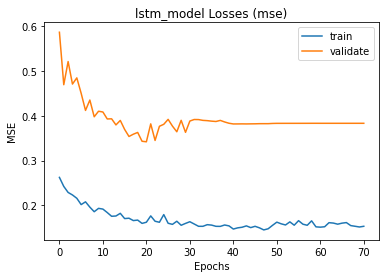

 40%|███████████████████▏                            | 4/10 [00:46<04:37, 46.21s/trial, best loss: 0.07926610246159677]WARNING:tensorflow:Large dropout rate: 0.758275 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
Train on 317 samples, validate on 124 samples                                                                          
Epoch 1/256                                                                                                            
 30/317 [=>............................]                                                                               
 - ETA: 17s - loss: 0.3363                                                                                             
                                                                                                                      
 60/317 [====>.........................]                                                                               


 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.2120                                                                                              
                                                                                                                       
120/317 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.2063                                                                                              
                                                                                                                       
150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.2069                                                                                              
                                        

 - ETA: 0s - loss: 0.1541                                                                                              
                                                                                                                       
180/317 [================>.............]                                                                               
 - ETA: 0s - loss: 0.1566                                                                                              
                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.1569                                                                                              
                                                                                                                       
240/317 [=====================>........]

                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.1391                                                                                              
                                                                                                                       
240/317 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.1409                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.1423               

240/317 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.1324                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.1295                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.1284                                                                                              
                                        

 - ETA: 0s - loss: 0.1216                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.1229                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.1221 - val_loss: 0.2134                                                                       

                                                                                                                       
Epoch 00011: val_loss improved from 0.2

 - ETA: 0s - loss: 0.1050                                                                                              
                                                                                                                       
 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.0987                                                                                              
                                                                                                                       
120/317 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.1080                                                                                              
                                                                                                                       
150/317 [=============>................]

                                                                                                                       
150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.1000                                                                                              
                                                                                                                       
180/317 [================>.............]                                                                               
 - ETA: 0s - loss: 0.0983                                                                                              
                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.1014               

180/317 [================>.............]                                                                               
 - ETA: 0s - loss: 0.1077                                                                                              
                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.1057                                                                                              
                                                                                                                       
240/317 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.1052                                                                                              
                                        

 - ETA: 0s - loss: 0.1008                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.1027                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.1021                                                                                              
                                                                                                                       
317/317 [==============================]

 - ETA: 0s - loss: 0.1172                                                                                              
                                                                                                                       
120/317 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.1130                                                                                              
                                                                                                                       
180/317 [================>.............]                                                                               
 - ETA: 0s - loss: 0.1072                                                                                              
                                                                                                                       
210/317 [==================>...........]

                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.1049                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.1010 - val_loss: 0.1551                                                                       

                                                                                                                       
Epoch 00025: val_loss improved from 0.15750 to 0.15512, saving model to Saved Models/Best_Model.ckpt
Epoch 26/256                                              

Epoch 28/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.1122                                                                                              
                                                                                                                       
 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.0857                                                                                              
                                                                                                                       
120/317 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.0865               

317/317 [==============================]                                                                               
 - 0s 1ms/step - loss: 0.0930 - val_loss: 0.1268                                                                       

                                                                                                                       
Epoch 00030: val_loss did not improve from 0.12394
Epoch 31/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.0697                                                                                              
                                                                                                                       
 90/317 [=======>......................]                                                                    

180/317 [================>.............]                                                                               
 - ETA: 0s - loss: 0.0975                                                                                              
                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.0948                                                                                              
                                                                                                                       
240/317 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.0905                                                                                              
                                        

                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.0900                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.0896                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.0888 - val_loss

 - ETA: 0s - loss: 0.0797                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.0806                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.0849                                                                                              
                                                                                                                       
317/317 [==============================]

 - 1s 2ms/step - loss: 0.0846 - val_loss: 0.1549                                                                       

                                                                                                                       
Epoch 00039: val_loss did not improve from 0.12394
Epoch 40/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.0819                                                                                              
                                                                                                                       
 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.0898                                                                                   

 - ETA: 0s - loss: 0.0801                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 0s 1ms/step - loss: 0.0820 - val_loss: 0.1470                                                                       

                                                                                                                       
Epoch 00042: val_loss did not improve from 0.12394
Epoch 43/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.0640                                                                                   

 - ETA: 0s - loss: 0.0872                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.0839                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.0841 - val_loss: 0.1468                                                                       

                                                                                                                       
Epoch 00045: val_loss did not improve f

 - ETA: 0s - loss: 0.0775                                                                                              
                                                                                                                       
180/317 [================>.............]                                                                               
 - ETA: 0s - loss: 0.0770                                                                                              
                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.0748                                                                                              
                                                                                                                       
240/317 [=====================>........]

 - ETA: 0s - loss: 0.0790                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.0782                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 0s 2ms/step - loss: 0.0794 - val_loss: 0.1468                                                                       

                                                                                                                       
Epoch 00050: val_loss did not improve f

 - ETA: 0s - loss: 0.0723                                                                                              
                                                                                                                       
150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.0761                                                                                              
                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.0838                                                                                              
                                                                                                                       
270/317 [========================>.....]

 - ETA: 0s - loss: 0.0800                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.0816                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 0s 1ms/step - loss: 0.0795 - val_loss: 0.1466                                                                       

                                                                                                                       
Epoch 00056: val_loss did not improve f

Epoch 60/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.0846                                                                                              
                                                                                                                       
 60/317 [====>.........................]                                                                               
 - ETA: 0s - loss: 0.0821                                                                                              
                                                                                                                       
120/317 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.0841               

Epoch 63/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.0980                                                                                              
                                                                                                                       
 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.0871                                                                                              
                                                                                                                       
150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.0809               

                                                                                                                       
120/317 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.0870                                                                                              
                                                                                                                       
150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.0858                                                                                              
                                                                                                                       
180/317 [================>.............]                                                                               
 - ETA: 0s - loss: 0.0854               

 - ETA: 0s - loss: 0.0834                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.0817                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.0806                                                                                              
                                                                                                                       
317/317 [==============================]

 - ETA: 0s - loss: 0.0766                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.0791                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.0801 - val_loss: 0.1466                                                                       

                                                                                                                       
Epoch 00070: val_loss did not improve f

300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.0800                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.0806 - val_loss: 0.1466                                                                       

                                                                                                                       
Epoch 00072: val_loss did not improve from 0.12394
Epoch 73/256                                                                                                           
 30/317 [=>............................]                                                                    

                                                                                                                       
Epoch 00074: val_loss did not improve from 0.12394
Epoch 75/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.0497                                                                                              
                                                                                                                       
 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.0780                                                                                              
                                                                                                             

                                                                                                                       
 60/317 [====>.........................]                                                                               
 - ETA: 0s - loss: 0.0789                                                                                              
                                                                                                                       
 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.0852                                                                                              
                                                                                                                       
120/317 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.0798               

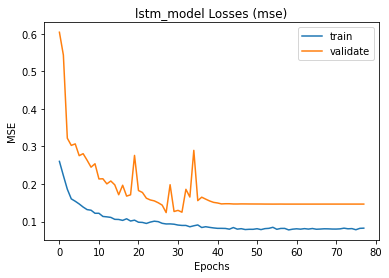

 50%|████████████████████████                        | 5/10 [01:51<04:20, 52.04s/trial, best loss: 0.07782148740222025]WARNING:tensorflow:Large dropout rate: 0.755907 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
Train on 317 samples, validate on 124 samples                                                                          
Epoch 1/256                                                                                                            
 30/317 [=>............................]                                                                               
 - ETA: 17s - loss: 0.2514                                                                                             
                                                                                                                      
 60/317 [====>.........................]                                                                               


                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.2059 - val_loss: 0.3275                                                                       

                                                                                                                       
Epoch 00002: val_loss improved from 0.57031 to 0.32748, saving model to Saved Models/Best_Model.ckpt
Epoch 3/256                                                                                                            
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.1731                                                                                              
                                                          

300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.1641                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 3ms/step - loss: 0.1646 - val_loss: 0.3170                                                                       

                                                                                                                       
Epoch 00004: val_loss improved from 0.32748 to 0.31703, saving model to Saved Models/Best_Model.ckpt
Epoch 5/256                                                                                                            
 30/317 [=>............................]                  

 - ETA: 0s - loss: 0.1455                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.1485                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.1496 - val_loss: 0.3216                                                                       

                                                                                                                       
Epoch 00006: val_loss did not improve f

                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.1379                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.1403                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.1421 - val_loss

240/317 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.1310                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.1299                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.1283                                                                                              
                                        

 - ETA: 0s - loss: 0.1244                                                                                              
                                                                                                                       
240/317 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.1237                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.1229                                                                                              
                                                                                                                       
300/317 [===========================>..]

210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.1133                                                                                              
                                                                                                                       
240/317 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.1131                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.1187                                                                                              
                                        

 - ETA: 0s - loss: 0.1219                                                                                              
                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.1179                                                                                              
                                                                                                                       
240/317 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.1172                                                                                              
                                                                                                                       
270/317 [========================>.....]

180/317 [================>.............]                                                                               
 - ETA: 0s - loss: 0.1231                                                                                              
                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.1229                                                                                              
                                                                                                                       
240/317 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.1184                                                                                              
                                        

 - ETA: 0s - loss: 0.1058                                                                                              
                                                                                                                       
180/317 [================>.............]                                                                               
 - ETA: 0s - loss: 0.1045                                                                                              
                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.1092                                                                                              
                                                                                                                       
240/317 [=====================>........]

                                                                                                                       
150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.1052                                                                                              
                                                                                                                       
180/317 [================>.............]                                                                               
 - ETA: 0s - loss: 0.1062                                                                                              
                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.1040               

120/317 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.0892                                                                                              
                                                                                                                       
150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.0917                                                                                              
                                                                                                                       
180/317 [================>.............]                                                                               
 - ETA: 0s - loss: 0.0993                                                                                              
                                        

                                                                                                                       
120/317 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.0995                                                                                              
                                                                                                                       
150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.0991                                                                                              
                                                                                                                       
180/317 [================>.............]                                                                               
 - ETA: 0s - loss: 0.1050               

 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.1205                                                                                              
                                                                                                                       
120/317 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.1144                                                                                              
                                                                                                                       
150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.1216                                                                                              
                                        

                                                                                                                       
 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.0993                                                                                              
                                                                                                                       
120/317 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.0998                                                                                              
                                                                                                                       
150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.1021               

 - ETA: 0s - loss: 0.0962                                                                                              
                                                                                                                       
 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.0939                                                                                              
                                                                                                                       
120/317 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.0974                                                                                              
                                                                                                                       
150/317 [=============>................]

 60/317 [====>.........................]                                                                               
 - ETA: 0s - loss: 0.1006                                                                                              
                                                                                                                       
 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.0993                                                                                              
                                                                                                                       
120/317 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.0987                                                                                              
                                        

                                                                                                                       
 60/317 [====>.........................]                                                                               
 - ETA: 0s - loss: 0.1016                                                                                              
                                                                                                                       
 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.0998                                                                                              
                                                                                                                       
120/317 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.1011               

Epoch 38/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.0808                                                                                              
                                                                                                                       
 60/317 [====>.........................]                                                                               
 - ETA: 0s - loss: 0.0925                                                                                              
                                                                                                                       
 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.0936               

                                                                                                                       
Epoch 00039: val_loss did not improve from 0.14267
Epoch 40/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.0921                                                                                              
                                                                                                                       
 60/317 [====>.........................]                                                                               
 - ETA: 0s - loss: 0.0951                                                                                              
                                                                                                             

 - 1s 2ms/step - loss: 0.0977 - val_loss: 0.1493                                                                       

                                                                                                                       
Epoch 00041: val_loss did not improve from 0.14267
Epoch 42/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.0841                                                                                              
                                                                                                                       
 60/317 [====>.........................]                                                                               
 - ETA: 0s - loss: 0.0894                                                                                   

317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.0982 - val_loss: 0.1489                                                                       

                                                                                                                       
Epoch 00043: val_loss did not improve from 0.14267
Epoch 44/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.1038                                                                                              
                                                                                                                       
 60/317 [====>.........................]                                                                    

                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.0995 - val_loss: 0.1499                                                                       

                                                                                                                       
Epoch 00045: val_loss did not improve from 0.14267
Epoch 46/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.0830                                                                                              
                                                                                                            

                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.0952                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.0953 - val_loss: 0.1488                                                                       

                                                                                                                       
Epoch 00047: val_loss did not improve from 0.14267
Epoch 48/256                                                                                                

 - ETA: 0s - loss: 0.0933                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.0964                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.0968 - val_loss: 0.1483                                                                       

                                                                                                                       
Epoch 00049: val_loss did not improve f

270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.0925                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.0927                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.0943 - val_loss: 0.1476                                                                       

                                       

                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.0992                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.0982                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.0988 - val_loss

 - ETA: 0s - loss: 0.0937                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.0945                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.0932                                                                                              
                                                                                                                       
317/317 [==============================]

 - ETA: 0s - loss: 0.0972                                                                                              
                                                                                                                       
240/317 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.0984                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.0990                                                                                              
                                                                                                                       
300/317 [===========================>..]

210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.1063                                                                                              
                                                                                                                       
240/317 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.1063                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.1011                                                                                              
                                        

                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.0966                                                                                              
                                                                                                                       
240/317 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.0978                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.0987               

 - ETA: 0s - loss: 0.0982                                                                                              
                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.0983                                                                                              
                                                                                                                       
240/317 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.0967                                                                                              
                                                                                                                       
270/317 [========================>.....]

180/317 [================>.............]                                                                               
 - ETA: 0s - loss: 0.0916                                                                                              
                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.0885                                                                                              
                                                                                                                       
240/317 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.0922                                                                                              
                                        

150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.0919                                                                                              
                                                                                                                       
180/317 [================>.............]                                                                               
 - ETA: 0s - loss: 0.0970                                                                                              
                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.0999                                                                                              
                                        

                                                                                                                       
150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.0949                                                                                              
                                                                                                                       
180/317 [================>.............]                                                                               
 - ETA: 0s - loss: 0.0958                                                                                              
                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.0970               

 - ETA: 0s - loss: 0.0953                                                                                              
                                                                                                                       
150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.0952                                                                                              
                                                                                                                       
180/317 [================>.............]                                                                               
 - ETA: 0s - loss: 0.0949                                                                                              
                                                                                                                       
210/317 [==================>...........]

120/317 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.0925                                                                                              
                                                                                                                       
150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.0966                                                                                              
                                                                                                                       
180/317 [================>.............]                                                                               
 - ETA: 0s - loss: 0.1005                                                                                              
                                        

                                                                                                                       
120/317 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.0996                                                                                              
                                                                                                                       
150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.1006                                                                                              
                                                                                                                       
180/317 [================>.............]                                                                               
 - ETA: 0s - loss: 0.1033               

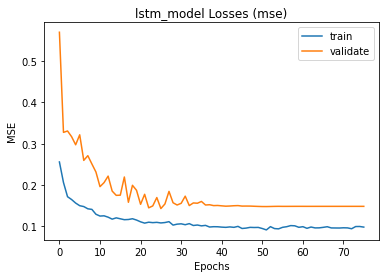

Train on 317 samples, validate on 124 samples                                                                          
Epoch 1/256                                                                                                            
 30/317 [=>............................]                                                                               
 - ETA: 18s - loss: 0.1994                                                                                             
                                                                                                                      
 60/317 [====>.........................]                                                                               
 - ETA: 8s - loss: 0.2310                                                                                              
                                                                                                                       
 90/317 [=======>......................] 

 - 1s 2ms/step - loss: 0.2300 - val_loss: 0.4117                                                                       

                                                                                                                       
Epoch 00002: val_loss improved from 0.49700 to 0.41168, saving model to Saved Models/Best_Model.ckpt
Epoch 3/256                                                                                                            
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.1935                                                                                              
                                                                                                                       
 60/317 [====>.........................]                                                                               
 - ETA: 0s - loss: 0.2067                                 

                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.2069 - val_loss: 0.3681                                                                       

                                                                                                                       
Epoch 00004: val_loss improved from 0.41168 to 0.36815, saving model to Saved Models/Best_Model.ckpt
Epoch 5/256                                                                                                            
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.2660                                                                                              
                                                          

300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.1909                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.1933 - val_loss: 0.3538                                                                       

                                                                                                                       
Epoch 00006: val_loss improved from 0.36815 to 0.35383, saving model to Saved Models/Best_Model.ckpt
Epoch 7/256                                                                                                            
 30/317 [=>............................]                  

 - ETA: 0s - loss: 0.1825                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.1803                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.1802 - val_loss: 0.3143                                                                       

                                                                                                                       
Epoch 00008: val_loss improved from 0.3

                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.1807                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.1804                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.1797 - val_loss

240/317 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.1740                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.1738                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.1736                                                                                              
                                        

 - ETA: 0s - loss: 0.1713                                                                                              
                                                                                                                       
240/317 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.1753                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.1697                                                                                              
                                                                                                                       
300/317 [===========================>..]

                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.1600                                                                                              
                                                                                                                       
240/317 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.1569                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.1574               

 - ETA: 0s - loss: 0.1576                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.1538                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.1586                                                                                              
                                                                                                                       
317/317 [==============================]

                                                                                                                       
240/317 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.1589                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.1563                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.1559               

 - ETA: 0s - loss: 0.1566                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.1594                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.1581                                                                                              
                                                                                                                       
317/317 [==============================]

240/317 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.1528                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.1516                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.1555                                                                                              
                                        

                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.1623                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.1592                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.1606 - val_loss

 - ETA: 0s - loss: 0.1538                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.1557 - val_loss: 0.2066                                                                       

                                                                                                                       
Epoch 00028: val_loss did not improve from 0.18357
Epoch 29/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.1453                                                                                   

 - ETA: 0s - loss: 0.1591                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.1561 - val_loss: 0.2315                                                                       

                                                                                                                       
Epoch 00030: val_loss did not improve from 0.18357
Epoch 31/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.1344                                                                                   

317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.1491 - val_loss: 0.1830                                                                       

                                                                                                                       
Epoch 00032: val_loss improved from 0.18357 to 0.18301, saving model to Saved Models/Best_Model.ckpt
Epoch 33/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.1204                                                                                              
                                                                                                                       
 60/317 [====>.........................]                  

 - ETA: 0s - loss: 0.1509                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.1522 - val_loss: 0.1924                                                                       

                                                                                                                       
Epoch 00034: val_loss did not improve from 0.18301
Epoch 35/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.1408                                                                                   

300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.1516                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.1495 - val_loss: 0.2063                                                                       

                                                                                                                       
Epoch 00036: val_loss did not improve from 0.18301
Epoch 37/256                                                                                                           
 30/317 [=>............................]                                                                    

                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.1478                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.1484 - val_loss: 0.1888                                                                       

                                                                                                                       
Epoch 00038: val_loss did not improve from 0.18301
Epoch 39/256                                                                                                

 - ETA: 0s - loss: 0.1458                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.1489                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.1485 - val_loss: 0.1920                                                                       

                                                                                                                       
Epoch 00040: val_loss did not improve f

270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.1517                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.1493                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.1497 - val_loss: 0.1818                                                                       

                                       

 - ETA: 0s - loss: 0.1451                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.1474                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.1462                                                                                              
                                                                                                                       
317/317 [==============================]

240/317 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.1451                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.1454                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.1458                                                                                              
                                        

                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.1423                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.1437                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.1475 - val_loss

 - ETA: 0s - loss: 0.1452                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.1443                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.1429                                                                                              
                                                                                                                       
317/317 [==============================]

                                                                                                                       
240/317 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.1444                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.1428                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.1447               

 - ETA: 0s - loss: 0.1436                                                                                              
                                                                                                                       
240/317 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.1467                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.1473                                                                                              
                                                                                                                       
300/317 [===========================>..]

210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.1455                                                                                              
                                                                                                                       
240/317 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.1499                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.1448                                                                                              
                                        

                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.1360                                                                                              
                                                                                                                       
240/317 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.1414                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.1402               

 - ETA: 0s - loss: 0.1451                                                                                              
                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.1434                                                                                              
                                                                                                                       
240/317 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.1460                                                                                              
                                                                                                                       
270/317 [========================>.....]

 - ETA: 0s - loss: 0.1506                                                                                              
                                                                                                                       
180/317 [================>.............]                                                                               
 - ETA: 0s - loss: 0.1543                                                                                              
                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.1502                                                                                              
                                                                                                                       
240/317 [=====================>........]

150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.1395                                                                                              
                                                                                                                       
180/317 [================>.............]                                                                               
 - ETA: 0s - loss: 0.1467                                                                                              
                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.1471                                                                                              
                                        

                                                                                                                       
150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.1620                                                                                              
                                                                                                                       
180/317 [================>.............]                                                                               
 - ETA: 0s - loss: 0.1601                                                                                              
                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.1600               

 - ETA: 0s - loss: 0.1457                                                                                              
                                                                                                                       
150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.1428                                                                                              
                                                                                                                       
180/317 [================>.............]                                                                               
 - ETA: 0s - loss: 0.1430                                                                                              
                                                                                                                       
210/317 [==================>...........]

120/317 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.1626                                                                                              
                                                                                                                       
150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.1574                                                                                              
                                                                                                                       
180/317 [================>.............]                                                                               
 - ETA: 0s - loss: 0.1516                                                                                              
                                        

 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.1637                                                                                              
                                                                                                                       
120/317 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.1621                                                                                              
                                                                                                                       
150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.1524                                                                                              
                                        

                                                                                                                       
 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.1234                                                                                              
                                                                                                                       
120/317 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.1247                                                                                              
                                                                                                                       
150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.1331               

 - ETA: 0s - loss: 0.1310                                                                                              
                                                                                                                       
 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.1434                                                                                              
                                                                                                                       
120/317 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.1443                                                                                              
                                                                                                                       
150/317 [=============>................]

 60/317 [====>.........................]                                                                               
 - ETA: 0s - loss: 0.1364                                                                                              
                                                                                                                       
 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.1524                                                                                              
                                                                                                                       
120/317 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.1534                                                                                              
                                        

                                                                                                                       
 60/317 [====>.........................]                                                                               
 - ETA: 0s - loss: 0.1395                                                                                              
                                                                                                                       
 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.1400                                                                                              
                                                                                                                       
120/317 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.1367               

Epoch 82/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.1340                                                                                              
                                                                                                                       
 60/317 [====>.........................]                                                                               
 - ETA: 0s - loss: 0.1156                                                                                              
                                                                                                                       
 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.1362               

                                                                                                                       
Epoch 00083: val_loss did not improve from 0.17497
Epoch 84/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.1749                                                                                              
                                                                                                                       
 60/317 [====>.........................]                                                                               
 - ETA: 0s - loss: 0.1490                                                                                              
                                                                                                             

 - 1s 3ms/step - loss: 0.1501 - val_loss: 0.1825                                                                       

                                                                                                                       
Epoch 00085: val_loss did not improve from 0.17497
Epoch 86/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.1467                                                                                              
                                                                                                                       
 60/317 [====>.........................]                                                                               
 - ETA: 0s - loss: 0.1525                                                                                   

317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.1445 - val_loss: 0.1825                                                                       

                                                                                                                       
Epoch 00087: val_loss did not improve from 0.17497
Epoch 88/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.1414                                                                                              
                                                                                                                       
 60/317 [====>.........................]                                                                    

                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.1448 - val_loss: 0.1825                                                                       

                                                                                                                       
Epoch 00089: val_loss did not improve from 0.17497
Epoch 90/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.1488                                                                                              
                                                                                                            

                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.1463                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.1451 - val_loss: 0.1825                                                                       

                                                                                                                       
Epoch 00091: val_loss did not improve from 0.17497
Epoch 92/256                                                                                                

 - ETA: 0s - loss: 0.1436                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.1471                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.1468 - val_loss: 0.1825                                                                       

                                                                                                                       
Epoch 00093: val_loss did not improve f

270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.1481                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.1461                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.1467 - val_loss: 0.1825                                                                       

                                       

                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.1497                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.1461                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.1469 - val_loss

 - ETA: 0s - loss: 0.1479                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.1474                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.1483                                                                                              
                                                                                                                       
317/317 [==============================]

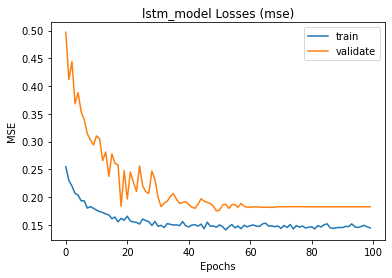

Train on 317 samples, validate on 124 samples                                                                          
Epoch 1/256                                                                                                            
 30/317 [=>............................]                                                                               
 - ETA: 20s - loss: 0.2900                                                                                             
                                                                                                                      
 60/317 [====>.........................]                                                                               
 - ETA: 9s - loss: 0.2609                                                                                              
                                                                                                                       
 90/317 [=======>......................] 

 - 1s 2ms/step - loss: 0.2132 - val_loss: 0.3591                                                                       

                                                                                                                       
Epoch 00002: val_loss improved from 0.57291 to 0.35912, saving model to Saved Models/Best_Model.ckpt
Epoch 3/256                                                                                                            
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.1984                                                                                              
                                                                                                                       
 60/317 [====>.........................]                                                                               
 - ETA: 0s - loss: 0.1827                                 

                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.1456 - val_loss: 0.2993                                                                       

                                                                                                                       
Epoch 00004: val_loss did not improve from 0.28697
Epoch 5/256                                                                                                            
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.1232                                                                                              
                                                                                                            

300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.1320                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.1334 - val_loss: 0.2522                                                                       

                                                                                                                       
Epoch 00006: val_loss improved from 0.25363 to 0.25221, saving model to Saved Models/Best_Model.ckpt
Epoch 7/256                                                                                                            
 30/317 [=>............................]                  

 - 1s 2ms/step - loss: 0.1196 - val_loss: 0.2111                                                                       

                                                                                                                       
Epoch 00008: val_loss improved from 0.24544 to 0.21108, saving model to Saved Models/Best_Model.ckpt
Epoch 9/256                                                                                                            
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.1329                                                                                              
                                                                                                                       
 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.1253                                 

                                                                                                                       
Epoch 00010: val_loss improved from 0.21108 to 0.20764, saving model to Saved Models/Best_Model.ckpt
Epoch 11/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.1097                                                                                              
                                                                                                                       
 60/317 [====>.........................]                                                                               
 - ETA: 0s - loss: 0.1071                                                                                              
                                                           

317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.1136 - val_loss: 0.2173                                                                       

                                                                                                                       
Epoch 00012: val_loss did not improve from 0.15651
Epoch 13/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.0854                                                                                              
                                                                                                                       
 60/317 [====>.........................]                                                                    

                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.1015 - val_loss: 0.1702                                                                       

                                                                                                                       
Epoch 00014: val_loss did not improve from 0.15651
Epoch 15/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.0853                                                                                              
                                                                                                            

 - ETA: 0s - loss: 0.0978                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.0972 - val_loss: 0.2134                                                                       

                                                                                                                       
Epoch 00016: val_loss did not improve from 0.15651
Epoch 17/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.0908                                                                                   

300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.0968                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.0958 - val_loss: 0.1698                                                                       

                                                                                                                       
Epoch 00018: val_loss did not improve from 0.15651
Epoch 19/256                                                                                                           
 30/317 [=>............................]                                                                    

                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.0929 - val_loss: 0.1765                                                                       

                                                                                                                       
Epoch 00020: val_loss did not improve from 0.15651
Epoch 21/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.0730                                                                                              
                                                                                                            

                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.0844                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 3ms/step - loss: 0.0826 - val_loss: 0.1785                                                                       

                                                                                                                       
Epoch 00022: val_loss did not improve from 0.15651
Epoch 23/256                                                                                                

 - ETA: 0s - loss: 0.0852                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.0845                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.0855 - val_loss: 0.1987                                                                       

                                                                                                                       
Epoch 00024: val_loss did not improve f

270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.0789                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.0801                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.0819 - val_loss: 0.1891                                                                       

                                       

                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.0843                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.0838                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 3ms/step - loss: 0.0848 - val_loss

 - ETA: 0s - loss: 0.0827                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.0834 - val_loss: 0.1800                                                                       

                                                                                                                       
Epoch 00030: val_loss did not improve from 0.15651
Epoch 31/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.0792                                                                                   

 - ETA: 0s - loss: 0.0832                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.0821                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.0823 - val_loss: 0.1810                                                                       

                                                                                                                       
Epoch 00032: val_loss did not improve f

270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.0872                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.0864                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.0857 - val_loss: 0.1820                                                                       

                                       

 60/317 [====>.........................]                                                                               
 - ETA: 0s - loss: 0.0829                                                                                              
                                                                                                                       
 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.0796                                                                                              
                                                                                                                       
120/317 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.0891                                                                                              
                                        

                                                                                                                       
 60/317 [====>.........................]                                                                               
 - ETA: 0s - loss: 0.1006                                                                                              
                                                                                                                       
 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.0962                                                                                              
                                                                                                                       
120/317 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.0937               

 - ETA: 0s - loss: 0.0724                                                                                              
                                                                                                                       
 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.0711                                                                                              
                                                                                                                       
120/317 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.0799                                                                                              
                                                                                                                       
150/317 [=============>................]

 - ETA: 0s - loss: 0.0799                                                                                              
                                                                                                                       
 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.0798                                                                                              
                                                                                                                       
120/317 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.0751                                                                                              
                                                                                                                       
150/317 [=============>................]

 - ETA: 0s - loss: 0.0515                                                                                              
                                                                                                                       
 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.0838                                                                                              
                                                                                                                       
150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.0821                                                                                              
                                                                                                                       
210/317 [==================>...........]

 - ETA: 0s - loss: 0.0882                                                                                              
                                                                                                                       
180/317 [================>.............]                                                                               
 - ETA: 0s - loss: 0.0835                                                                                              
                                                                                                                       
240/317 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.0875                                                                                              
                                                                                                                       
300/317 [===========================>..]

180/317 [================>.............]                                                                               
 - ETA: 0s - loss: 0.0874                                                                                              
                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.0858                                                                                              
                                                                                                                       
240/317 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.0861                                                                                              
                                        

150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.0945                                                                                              
                                                                                                                       
180/317 [================>.............]                                                                               
 - ETA: 0s - loss: 0.0912                                                                                              
                                                                                                                       
240/317 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.0875                                                                                              
                                        

270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.0807                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 0s 1ms/step - loss: 0.0820 - val_loss: 0.1872                                                                       

                                                                                                                       
Epoch 00058: val_loss did not improve from 0.15651
Epoch 59/256                                                                                                           
 30/317 [=>............................]                                                                    

Restoring model weights from the end of the best epoch                                                                 
                                                                                                                       
Epoch 00061: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
Epoch 00061: early stopping                                                                                            
 70%|█████████████████████████████████▌              | 7/10 [05:38<03:28, 69.44s/trial, best loss: 0.07782148740222025]

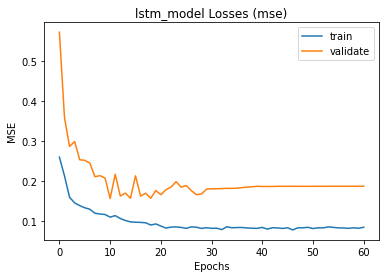

Train on 317 samples, validate on 124 samples                                                                          
Epoch 1/256                                                                                                            
 30/317 [=>............................]                                                                               
 - ETA: 22s - loss: 0.2586                                                                                             
                                                                                                                      
 90/317 [=======>......................]                                                                               
 - ETA: 6s - loss: 0.2548                                                                                              
                                                                                                                       
150/317 [=============>................] 

 - ETA: 0s - loss: 0.2491                                                                                              
                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.2528                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.2561                                                                                              
                                                                                                                       
317/317 [==============================]

 - 0s 1ms/step - loss: 0.2612 - val_loss: 0.6193                                                                       

                                                                                                                       
Epoch 00007: val_loss improved from 0.62658 to 0.61933, saving model to Saved Models/Best_Model.ckpt
Epoch 8/256                                                                                                            
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.2694                                                                                              
                                                                                                                       
 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.2528                                 

                                                                                                                       
150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.2604                                                                                              
                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.2513                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.2577               

 - ETA: 0s - loss: 0.2466                                                                                              
                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.2398                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.2443                                                                                              
                                                                                                                       
317/317 [==============================]

 - ETA: 0s - loss: 0.2507                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 0s 1ms/step - loss: 0.2484 - val_loss: 0.5931                                                                       

                                                                                                                       
Epoch 00017: val_loss did not improve from 0.59245
Epoch 18/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.2128                                                                                   

                                                                                                                       
 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.2377                                                                                              
                                                                                                                       
150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.2363                                                                                              
                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.2275               

                                                                                                                       
150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.2351                                                                                              
                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.2314                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.2367               

                                                                                                                       
317/317 [==============================]                                                                               
 - 0s 1ms/step - loss: 0.2348 - val_loss: 0.5537                                                                       

                                                                                                                       
Epoch 00027: val_loss improved from 0.56399 to 0.55369, saving model to Saved Models/Best_Model.ckpt
Epoch 28/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.1788                                                                                              
                                                          

 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.2420                                                                                              
                                                                                                                       
 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.2220                                                                                              
                                                                                                                       
150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.2249                                                                                              
                                        

150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.2422                                                                                              
                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.2409                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.2353                                                                                              
                                        

317/317 [==============================]                                                                               
 - 0s 1ms/step - loss: 0.2351 - val_loss: 0.5526                                                                       

                                                                                                                       
Epoch 00037: val_loss did not improve from 0.54955
Epoch 38/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.2554                                                                                              
                                                                                                                       
 90/317 [=======>......................]                                                                    

                                                                                                                       
 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.2829                                                                                              
                                                                                                                       
150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.2636                                                                                              
                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.2517               

                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.2416                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.2353                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 0s 1ms/step - loss: 0.2370 - val_loss

                                                                                                                       
Epoch 00047: val_loss did not improve from 0.54169
Epoch 48/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.2949                                                                                              
                                                                                                                       
 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.2704                                                                                              
                                                                                                             

 - ETA: 0s - loss: 0.2492                                                                                              
                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.2270                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.2259                                                                                              
                                                                                                                       
317/317 [==============================]

317/317 [==============================]                                                                               
 - 0s 1ms/step - loss: 0.2246 - val_loss: 0.5456                                                                       

                                                                                                                       
Epoch 00054: val_loss did not improve from 0.54169
Epoch 55/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.2395                                                                                              
                                                                                                                       
 90/317 [=======>......................]                                                                    

                                                                                                                       
150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.2494                                                                                              
                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.2378                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.2302               

                                                                                                                       
317/317 [==============================]                                                                               
 - 0s 1ms/step - loss: 0.2373 - val_loss: 0.5430                                                                       

                                                                                                                       
Epoch 00061: val_loss did not improve from 0.54169
Epoch 62/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.2860                                                                                              
                                                                                                            

Epoch 65/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.2792                                                                                              
                                                                                                                       
 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.2678                                                                                              
                                                                                                                       
150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.2454               

                                                                                                                       
180/317 [================>.............]                                                                               
 - ETA: 0s - loss: 0.2185                                                                                              
                                                                                                                       
240/317 [=====================>........]                                                                               
 - ETA: 0s - loss: 0.2241                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.2200               

                                                                                                                       
317/317 [==============================]                                                                               
 - 0s 1ms/step - loss: 0.2272 - val_loss: 0.5438                                                                       

                                                                                                                       
Epoch 00071: val_loss did not improve from 0.54169
Epoch 72/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.1829                                                                                              
                                                                                                            

                                                                                                                       
 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.2462                                                                                              
                                                                                                                       
150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.2309                                                                                              
                                                                                                                       
180/317 [================>.............]                                                                               
 - ETA: 0s - loss: 0.2330               

                                                                                                                       
150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.2335                                                                                              
                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.2435                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.2295               

                                                                                                                       
317/317 [==============================]                                                                               
 - 0s 1ms/step - loss: 0.2313 - val_loss: 0.5438                                                                       

                                                                                                                       
Epoch 00081: val_loss did not improve from 0.54169
Epoch 82/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.2437                                                                                              
                                                                                                            

                                                                                                                       
 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.2297                                                                                              
                                                                                                                       
150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.2228                                                                                              
                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.2265               

                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.2306                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.2352                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 0s 1ms/step - loss: 0.2310 - val_loss

                                                                                                                       
Epoch 00091: val_loss did not improve from 0.54169
Epoch 92/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.2409                                                                                              
                                                                                                                       
 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.2431                                                                                              
                                                                                                             

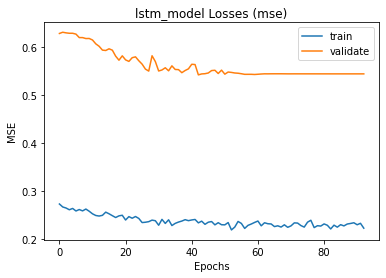

Train on 317 samples, validate on 124 samples                                                                          
Epoch 1/256                                                                                                            
 30/317 [=>............................]                                                                               
 - ETA: 22s - loss: 0.2663                                                                                             
                                                                                                                      
 90/317 [=======>......................]                                                                               
 - ETA: 6s - loss: 0.2224                                                                                              
                                                                                                                       
150/317 [=============>................] 

 60/317 [====>.........................]                                                                               
 - ETA: 0s - loss: 0.1458                                                                                              
                                                                                                                       
 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.1622                                                                                              
                                                                                                                       
120/317 [==========>...................]                                                                               
 - ETA: 0s - loss: 0.1612                                                                                              
                                        

 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.1470                                                                                              
                                                                                                                       
 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.1632                                                                                              
                                                                                                                       
150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.1597                                                                                              
                                        

210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.1279                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.1291                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 0s 1ms/step - loss: 0.1277 - val_loss: 0.2069                                                                       

                                       

317/317 [==============================]                                                                               
 - 0s 1ms/step - loss: 0.1207 - val_loss: 0.1706                                                                       

                                                                                                                       
Epoch 00013: val_loss did not improve from 0.16820
Epoch 14/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.1578                                                                                              
                                                                                                                       
 90/317 [=======>......................]                                                                    

 - ETA: 0s - loss: 0.1123                                                                                              
                                                                                                                       
150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.1076                                                                                              
                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.1120                                                                                              
                                                                                                                       
270/317 [========================>.....]

 - ETA: 0s - loss: 0.1069                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.1051                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 0s 2ms/step - loss: 0.1042 - val_loss: 0.1433                                                                       

                                                                                                                       
Epoch 00020: val_loss improved from 0.1

210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.0971                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.0948                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 0s 1ms/step - loss: 0.0967 - val_loss: 0.1368                                                                       

                                       

Epoch 27/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.1050                                                                                              
                                                                                                                       
 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.0893                                                                                              
                                                                                                                       
150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.0895               

                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.0922                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.0944                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 0s 1ms/step - loss: 0.0938 - val_loss

                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.0847                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.0902                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 0s 1ms/step - loss: 0.0893 - val_loss

                                                                                                                       
Epoch 00036: val_loss did not improve from 0.11945
Epoch 37/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.0883                                                                                              
                                                                                                                       
 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.0981                                                                                              
                                                                                                             

 - ETA: 0s - loss: 0.0889                                                                                              
                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.0884                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.0885                                                                                              
                                                                                                                       
317/317 [==============================]

 - ETA: 0s - loss: 0.0773                                                                                              
                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.0798                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.0805                                                                                              
                                                                                                                       
317/317 [==============================]

 - 0s 1ms/step - loss: 0.0853 - val_loss: 0.1176                                                                       

                                                                                                                       
Epoch 00046: val_loss did not improve from 0.11181
Epoch 47/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.0728                                                                                              
                                                                                                                       
 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.0741                                                                                   

 - 0s 2ms/step - loss: 0.0850 - val_loss: 0.1160                                                                       

                                                                                                                       
Epoch 00049: val_loss did not improve from 0.11181
Epoch 50/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.1053                                                                                              
                                                                                                                       
 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.0921                                                                                   

Epoch 53/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.0778                                                                                              
                                                                                                                       
 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.0740                                                                                              
                                                                                                                       
150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.0814               

                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.0761                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.0812                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 0s 1ms/step - loss: 0.0798 - val_loss

                                                                                                                       
317/317 [==============================]                                                                               
 - 0s 2ms/step - loss: 0.0792 - val_loss: 0.1199                                                                       

                                                                                                                       
Epoch 00059: val_loss did not improve from 0.11181
Epoch 60/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.0813                                                                                              
                                                                                                            

Epoch 63/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.0802                                                                                              
                                                                                                                       
 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.0796                                                                                              
                                                                                                                       
150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.0807               

                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.0776                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.0811                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 0s 1ms/step - loss: 0.0786 - val_loss

                                                                                                                       
Epoch 00069: val_loss did not improve from 0.11181
Epoch 70/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.0869                                                                                              
                                                                                                                       
 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.0760                                                                                              
                                                                                                             

Epoch 73/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.0642                                                                                              
                                                                                                                       
 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.0720                                                                                              
                                                                                                                       
150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.0769               

                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.0814                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.0791                                                                                              
                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.0807               

                                                                                                                       
300/317 [===========================>..]                                                                               
 - ETA: 0s - loss: 0.0791                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.0792 - val_loss: 0.1165                                                                       

                                                                                                                       
Epoch 00079: val_loss did not improve from 0.11181
Epoch 80/256                                                                                                

 - ETA: 0s - loss: 0.0854                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 1s 2ms/step - loss: 0.0838 - val_loss: 0.1165                                                                       

                                                                                                                       
Epoch 00082: val_loss did not improve from 0.11181
Epoch 83/256                                                                                                           
 30/317 [=>............................]                                                                               
 - ETA: 0s - loss: 0.0932                                                                                   

 90/317 [=======>......................]                                                                               
 - ETA: 0s - loss: 0.0754                                                                                              
                                                                                                                       
150/317 [=============>................]                                                                               
 - ETA: 0s - loss: 0.0724                                                                                              
                                                                                                                       
210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.0726                                                                                              
                                        

210/317 [==================>...........]                                                                               
 - ETA: 0s - loss: 0.0798                                                                                              
                                                                                                                       
270/317 [========================>.....]                                                                               
 - ETA: 0s - loss: 0.0787                                                                                              
                                                                                                                       
317/317 [==============================]                                                                               
 - 0s 1ms/step - loss: 0.0793 - val_loss: 0.1165                                                                       

                                       

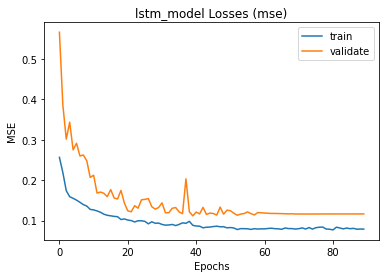

100%|███████████████████████████████████████████████| 10/10 [07:45<00:00, 66.44s/trial, best loss: 0.07699849520007894]
Execution time =  8 minutes


C:\Users\hp\anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


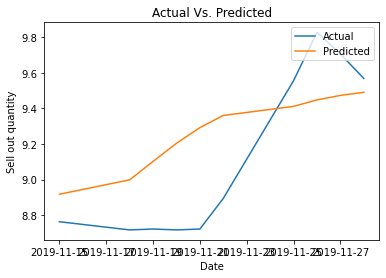

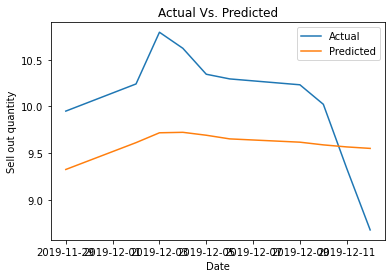

Average mape over 1 iterations 5.077705419336649


In [44]:
# execute model objective function
start_time = time.time()

# function minimize
fmin_objective = partial(objective, 
                         X_train = X_train, 
                         Y_train = Y_train, 
                         X_validate = X_validate , 
                         Y_validate = Y_validate,
                         path = path,
                         n_steps_out = n_steps_out
                         )
# function call
best_model = fmin(fmin_objective, 
            space, 
            algo=tpe.suggest, 
            trials=trials,
            max_evals= 10)

# Save the trials
trial_name = path + 'Best_Model.pkl'
joblib.dump(trials, trial_name)
best_model_trial = trials.best_trial

print("Execution time = ", (round((time.time() - start_time)/60)),'minutes')


'''                     Walk forward forecast on Test Dataset                    '''

# prepare test data
test = prepare_data('2019-11-01','2019-12-31')

# scaling test
test_scaled = scaler.fit_transform(test)

n_weeks = 2
mape_dict={}
rmse_dict = {}

i = 0
for i in range(0,n_weeks):
    
    # check if shifting exceeded data
    if i*n_steps_out + n_steps_in + n_steps_out> len(test_scaled):
        print("Breaking out, shifting exceeded data",i*n_steps_out + n_steps_in+ n_steps_out)
        break
    
    X_test = test_scaled[i*n_steps_out:n_steps_in + i*n_steps_out].reshape(1,n_steps_in,n_features)
    Y_test = test.iloc[n_steps_in+ i*n_steps_out:n_steps_in+ i*n_steps_out+ n_steps_out,:]
       
    # predicting on test
    saved_lstm_model = load_model(path + 'Best_Model.ckpt')
    Y_test_predictions = saved_lstm_model.predict(X_test)
    
    # reshaping Y_test and Y_test_predictions
    Y_test_predictions = Y_test_predictions.reshape(-1,1)
    
    # inverse transforming predictions 
    Y_test_predictions = scaler.inverse_transform(Y_test_predictions)
    
    # converting to dataframe
    Y_test_predictions = pd.DataFrame(Y_test_predictions).set_index(Y_test.index).rename(columns={0:'c5 predictions'})
    
    # model evaluation 
    mape, RMSE = evaluation(Y_test,Y_test_predictions)
    mape_dict[i], rmse_dict[i] = mape, RMSE
    
print("Average mape over " + str(i) + " iterations", statistics.mean(mape_dict[k] for k in mape_dict))

The LSTM model forecasts with an average MAPE score of 5.07 over 2 weeks of foreacst, which is a great result.

Future work:
Spot Freight Price Index is like stock market index, it is very volatile and sentiment driven. Hence, future work may include
improving feature selection, collecting text data, eg. Whatsapp messages, news, announcement to predict spot market using NLP-based features too.
